# Approximate Bayesian Compatation Sequential Monte Carlo
(or ABC Population Monte Carlo)

In [1]:
import hypothesis
import matplotlib.pyplot as plt
import torch

As in every Bayesian inference setting we have to define a prior $p(\theta)$, which is in our case $\mathcal{U}(-10, 10)$.

In [2]:
from torch.distributions.uniform import Uniform

lower = torch.tensor([-10]).float()
upper = torch.tensor([10]).float()
prior = Uniform(lower, upper)

The simulation-based or likelihood-free setting also requires the definition of a forward model.

In [3]:
from hypothesis.simulation import Simulator

class NormalSimulator(Simulator):
    
    def __init__(self):
        super(NormalSimulator, self).__init__()
        
    def forward(self, inputs):
        inputs = inputs.view(-1, 1)

        return torch.randn(inputs.size(0), 1) + inputs

simulator = NormalSimulator()

Let's check how the joint $p(\theta,x)$ looks like.

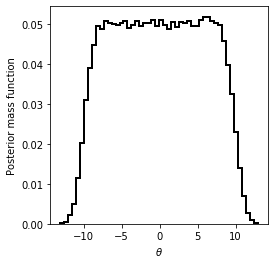

In [4]:
from hypothesis.visualization.util import make_square

n = torch.Size([100000])
inputs = prior.sample(n)
outputs = simulator(inputs)

plt.hist(outputs.numpy(), bins=50, density=True, color="black", histtype="step", lw=2)
plt.xlabel(r"$\theta$")
plt.ylabel("Posterior mass function")
make_square(plt.gca())
plt.show()

Every Bayesian setting requires an observation $x$ (or a set of observations) to compute the posterior of:

In [5]:
truth = prior.sample()
observation = simulator(truth)

print("Observation:", observation.item())

Observation: 3.7167582511901855


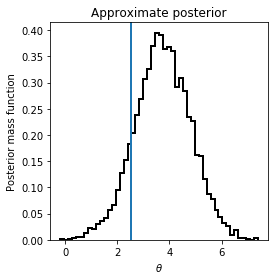

CPU times: user 6.2 s, sys: 158 ms, total: 6.35 s
Wall time: 6.13 s


In [6]:
%%time

from hypothesis.inference.abc_smc import ApproximateBayesianComputationSequentialMonteCarlo as ABCSMC

def acceptor(a, b, epsilon=1):
    return (a - b).abs().item() < epsilon

def plot_posterior(posterior_samples):
    plt.title("Approximate posterior")
    plt.hist(posterior_samples.numpy(), bins=50, color="black", histtype="step", density=True, lw=2)
    plt.xlabel(r"$\theta$")
    plt.ylabel("Posterior mass function")
    plt.axvline(truth, c="C0", lw=2)
    make_square(plt.gca())
    plt.show()

# Use the identity function as a summary statistic.
def identity(x):
    return x
    
# Allocate the inference procedure.
abc = ABCSMC(simulator=simulator,
    prior=prior,
    summary=identity,
    acceptor=acceptor)

# Sample the approximate posterior. We don't want gradients here (but you can).
with torch.no_grad():
    posterior_samples = abc.sample(observation, num_samples=10000)
    
# Plot the approximate posterior.
plot_posterior(posterior_samples)

Looking at the wallclock time, this is orders of magnitude faster compared to classical ABC because the population of particles focusses on areas of the parameter space which previously yielded accepted samples.